# M.0 Data initialization

In [50]:
#import datetime
from datetime import datetime, timedelta, date

import pyspark
import pyspark.sql.functions as f
from pyspark import SparkContext
from pyspark.sql import *
from pyspark.sql.types import *

import warnings
warnings.filterwarnings('ignore')

In [51]:
NUMBER_OF_THREADS_TO_USE = "*"
spark = SparkSession.builder \
    .master('local[' + NUMBER_OF_THREADS_TO_USE + ']') \
    .appName('discret_TestProcedures') \
    .config('spark.driver.memory', '200g') \
    .config('spark.driver.maxResultSize', '30g') \
    .config('spark.rapids.sql.enabled','true') \
    .getOrCreate()
sc = spark.sparkContext

spark

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import json

from shapely.geometry import shape, Point, Polygon


import geopy.distance


import warnings
warnings.filterwarnings('ignore')

import sys
import os






# found how to navigate between weeks here
# https://stackoverflow.com/questions/304256/whats-the-best-way-to-find-the-inverse-of-datetime-isocalendar

def iso_year_start(iso_year):
    #"The gregorian calendar date of the first day of the given ISO year"
    fourth_jan = date(iso_year, 1, 4)
    delta = timedelta(fourth_jan.isoweekday()-1)
    return fourth_jan - delta 

def iso_to_gregorian(iso_year, iso_week, iso_day):
    #"Gregorian calendar date for the given ISO year, week and day"
    year_start = iso_year_start(iso_year)
    return year_start + timedelta(days=iso_day-1, weeks=iso_week-1)


# framacalc seems to use excel format for dates
# so here's the conversion tool according to: https://www.semicolonworld.com/question/56907/how-to-convert-a-given-ordinal-number-from-excel-to-a-date

def from_excel_ordinal(ordinal, _epoch0=datetime(1899, 12, 31)):
    if ordinal >= 60:
        ordinal -= 1  # Excel leap year bug, 1900 is not a leap year!
    return (_epoch0 + timedelta(days=ordinal)).replace(microsecond=0)




In [244]:
meta = ['COORD_X','LAT','COORD_Y','LON','Date']
coords = ['COORD_X','LAT','COORD_Y','LON']
metrics = ['Voice','SMS_3G','PS','CS','Call','SMS_4G','Service_Req','HO']

LocationPrefix = "Paris"
DatasetPrefix = "Cancan"


#AlertsSourceParquetFile = "/WORKSPACE/Pierre/exports/Cancan_Paris_anomaly_levels"
#AlertsSourceParquetFile = "/WORKSPACE/Pierre/DataStefania/forPierre/voix/"
#AlertsSourceParquetFile = "/WORKSPACE/Pierre/DataStefania/forPierre/servReq/"
#AlertsSourceParquetFile = "/rapids/notebooks/LICIT_COMMON_Folder/LICIT_INPUT/notebooks/notebooks_pierre/forPierre/VoixStefania02/"
#AlertsSourceParquetFile = "/rapids/notebooks/LICIT_COMMON_Folder/LICIT_INPUT/notebooks/tools/DetectionParquets/Voix2112Red/"
#AlertsSourceParquetFile = "/rapids/notebooks/LICIT_COMMON_Folder/LICIT_INPUT/notebooks/tools/DetectionParquets/Voix1412Red/"
#AlertsSourceParquetFile = "/WORKSPACE/Pierre/exports/Cancan_Paris_alerts_eric_rel_parquet"


#AlertsSourceParquetFile = "/WORKSPACE/Pierre/exports/Cancan_Paris_anomaly_levels"
#AlertsSourceParquetFile = "/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris_detection_corrected/"
#AlertsSourceParquetFile = "/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris_detection_OriginalSplit_VoiceCall/"
#AlertsSourceParquetFile = "/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris_detection_OriginalSplit_VoiceCall_6Thresh/"
#AlertsSourceParquetFile = "/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris_detection_OriginalSplit_SMS3G4G_6Thresh/"
#AlertsSourceParquetFile = "/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris_detection_OriginalSplit_CallSMS/"
#AlertsSourceParquetFile = "/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris_detection_OriginalSplit_VoiceSMS_6Thresh/"
#AlertsSourceParquetFile = "/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris_detection_OriginalSplit_VoiceOnly_6Thresh/"
#AlertsSourceParquetFile = "/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris_detection_OriginalSplit_CallOnly_6Thresh/"
#AlertsSourceParquetFile = "/WORKSPACE/Pierre/StefaniaResults/Cancan2022_Paris_detection_OriginalSplit_SMS3G4G_6Thresh/"





#AlertsSourceParquetFile = "/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris_detection_OriginalSplit_Call4G_6Thresh/"

AlertsSourceParquetFile = "/WORKSPACE/Pierre/Cancan2022/Cancan2022_Paris_detection_OriginalSplit_CallSMS3G_6Thresh/"



# stefania's results
# thresholds set by us
#AlertsSourceParquetFile = "/WORKSPACE/Pierre/Cancan2022/Cancan2022_alerts_Stefania/"
#AlertsSourceParquetFile = "/WORKSPACE/Pierre/Cancan2022/Cancan2022_alerts_Stefania_6Thresh"
# thresholds set by her
#AlertsSourceParquetFile = "/rapids/notebooks/LICIT_COMMON_Folder/LICIT_INPUT/notebooks/tools/DetectionParquets/Voix2001Red"
#AlertsSourceParquetFile = "/rapids/notebooks/LICIT_COMMON_Folder/LICIT_INPUT/notebooks/tools/DetectionParquets/Voix1412Red/"


ExpectedAnomaliesFile = "20211005_DiscretExpectedAnomalies.csv"
#AntennasLocInfosFile = "/WORKSPACE/Pierre/exports/" + LocationPrefix + "_" + DatasetPrefix + "_LocInfo_Ids.csv"
AntennasLocInfosFile = "/WORKSPACE/Pierre/Cancan2022/Paris_LocInfo_Ids_3.csv"



MethodName = "Signature_CallSMS3G_6Thresh"
#MethodName = "Signature_VoiceCall_6Thresh"
#MethodName = "Stefania_6Thresh"
AggregatedResultsStoreCsvFile = "exports/20221027 - Aggregated Results.csv"



In [245]:
# load source data
#DetectionsSparkDF = spark.read.parquet(AlertsSourceParquetFile).drop("__index_level_0__")
DetectionsSparkDF = spark.read.parquet(AlertsSourceParquetFile)

# handle Stefania's format
# handle new Cancan format....
listDSPFColumns = DetectionsSparkDF.columns
if "WeekOfYear"  in listDSPFColumns:
    print("newer Cancan with mod separation detected")
    DetectionsSparkDF = DetectionsSparkDF.drop("__index_level_0__").withColumnRenamed('WeekOfYear', 'week_of_year')
elif "__index_level_0__"  in listDSPFColumns:
    print("Stefania's output detected")
    DetectionsSparkDF = DetectionsSparkDF.drop("__index_level_0__")
    DetectionsSparkDF = DetectionsSparkDF.withColumn('week_of_year', f.col('week_of_year') + f.lit(1))
else:
    # remove the metrics, which are not used here
    for m in metrics:
        if m in listDSPFColumns:
            DetectionsSparkDF = DetectionsSparkDF.drop(m)
    
# also filter out week 11 which is too prone to errors
DetectionsSparkDF = DetectionsSparkDF.filter(DetectionsSparkDF.week_of_year>11)
#DetectionsSparkDF = DetectionsSparkDF.filter( (DetectionsSparkDF.week_of_year<20) & (DetectionsSparkDF.week_of_year>15) )

#DetectionsSparkDF = DetectionsSparkDF.withColumn('week_of_year', f.col('week_of_year') + f.lit(1))
DetectionsSparkDF.printSchema()

# load the events table
RecordedEventsDF = pd.read_csv(ExpectedAnomaliesFile)
print(RecordedEventsDF.info(verbose=True))

# now, order antennas according to their known position
AntennasLocInfosDF = pd.read_csv(AntennasLocInfosFile)
print(AntennasLocInfosDF.info(verbose=True))


newer Cancan with mod separation detected
root
 |-- MinuteWithinWeek: long (nullable = true)
 |-- WeeksGroup: long (nullable = true)
 |-- LocationId: long (nullable = true)
 |-- ALR: double (nullable = true)
 |-- Anomaly_Level: long (nullable = true)
 |-- week_of_year: integer (nullable = true)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Dataset                     87 non-null     object 
 1   Event_Surname               87 non-null     object 
 2   Major event                 15 non-null     float64
 3   Temporal spread             87 non-null     object 
 4   Spatial spread              86 non-null     object 
 5   Date_start                  87 non-null     float64
 6   Date_end                    16 non-null     float64
 7   Date_series                 4 non-null      object 
 8   Date_interval            

In [246]:
# know on which weeks and Location Ids we have performed the detection
LocIdsList = sorted([x.LocationId for x in DetectionsSparkDF.select('LocationId').distinct().collect()])
print("found " + str(len(LocIdsList)) + " location groups")
#print(LocIdsList)

WeekIdsList = sorted([x.week_of_year for x in DetectionsSparkDF.select('week_of_year').distinct().collect()])
print("found " + str(len(WeekIdsList)) + " different weeks")
print(WeekIdsList)

AnomalyList = sorted([x.Anomaly_Level for x in DetectionsSparkDF.select('Anomaly_Level').distinct().collect()])
print("found " + str(len(AnomalyList)) + " different anomaly levels")
print(AnomalyList)




found 1026 location groups


found 13 different weeks
[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
found 7 different anomaly levels
[0, 1, 2, 3, 4, 5, 6]


In [247]:
MaxAnomLevel = max(AnomalyList)
print(MaxAnomLevel)

6


## Preprocess Annotations

In [248]:



# now run through the list of expected events, and determine the closest antenna groups, by rank and by limiting the max possible distance

MaxExpectedRank = 10
MaxExpectedDistance = 1











# format it properly (set the right types, handle NaN situations, etc etc)
RecordedEventsDF['Major event'] = RecordedEventsDF['Major event'].fillna(False).astype('bool')
RecordedEventsDF['Date_end'] = RecordedEventsDF['Date_end'].fillna(0).astype('int')
RecordedEventsDF['Date_series'] = RecordedEventsDF['Date_series'].fillna('').astype('string')
RecordedEventsDF['Date_interval'] = RecordedEventsDF['Date_interval'].fillna(False).astype('bool')
RecordedEventsDF['WGS84 Coordinates (DD)'] = RecordedEventsDF['WGS84 Coordinates (DD)'].fillna('').astype('string')
RecordedEventsDF['Temporal spread'] = RecordedEventsDF['Temporal spread'].fillna('').astype('string')
RecordedEventsDF['Spatial spread'] = RecordedEventsDF['Spatial spread'].fillna('').astype('string')



#RecordedEvents.describe()


TimeStartLoc = RecordedEventsDF.columns.get_loc('Time_start')
TimeEndLoc = RecordedEventsDF.columns.get_loc('Time_end')



ExpectedEventsList = []





count = 0

for index, row in RecordedEventsDF.iterrows():
    #print(row['Date_start'])
    
    if row['Dataset']!="Cancan":
        continue
        
    #if row['Major event']!=True:
    #    continue
    
    TimeDateSeries = []
    
    if len(row['Date_series'])>1:
        #print("now we have to handle date series")
        
        timeSerie = row['Date_series'].split(';') # we will remove spaces later to avoid issues caused by wrong formatting
        
        for i in range(0, len(timeSerie)):
            while timeSerie[i][0] == ' ':
                timeSerie[i] = timeSerie[i][1:]
            while timeSerie[i][-1] == ' ':
                timeSerie[i] = timeSerie[i][:-1]
            
            CurrDate = datetime.strptime(timeSerie[i], '%Y-%m-%d')
            
            CurrDateStartTime = CurrDate
            
            knownStartTime = not pd.isna(RecordedEventsDF.iloc[index,TimeStartLoc])
            
            if knownStartTime:
                CurrDateStartTime += timedelta(seconds=int(row['Time_start']*24*60*60))
                
            TimeDict = {'start': CurrDateStartTime + timedelta(seconds=0), 'knownStartTime': knownStartTime}
            
            if not pd.isna(RecordedEventsDF.iloc[index,TimeEndLoc]):
                CurrDateEndTime = CurrDate + timedelta(seconds=int(row['Time_end']*24*60*60))
                TimeDict['end'] = CurrDateEndTime
                
            TimeDateSeries.append(TimeDict)

    else:
        StartDate = from_excel_ordinal(row['Date_start'])
        
        StartDateWithTime = StartDate
        
        knownStartTime = not pd.isna(RecordedEventsDF.iloc[index,TimeStartLoc])
        
        if knownStartTime:
            StartDateWithTime += timedelta(seconds=int(row['Time_start']*24*60*60))
            
        TimeDict = {'start': StartDateWithTime + timedelta(seconds=0), 'knownStartTime': knownStartTime}
        
#        StartDateWithTime = StartDate + timedelta(seconds=int(row['Time_start']*24*60*60))
        
        #TimeDateSeries.append({'start')
        if row['Date_end']>0 and not row['Date_interval']:
            # this event has an ending date
            # no date series, so all days in between are included
            # if there is a time_start and a time_end, we add time intervals
            # otherwise, just starting events
            DaysNumber = int(row['Date_end'] - row['Date_start'] + 1)
            
            #TimeDictLocal = copy.deepcopy(TimeDict)
            
            for i in range(0, DaysNumber):
                #CurrDay = StartDate + timedelta(days=i)
                CurrDayStartTime = StartDateWithTime + timedelta(days=i)
                #print(CurrDayStartTime)
                
                TimeDictLocal = {'start': StartDateWithTime + timedelta(days=i), 'knownStartTime': knownStartTime}
                
                #TimeDictLocal['start'] = copy.deepcopy(CurrDayStartTime)
                
                if pd.isna(RecordedEventsDF.iloc[index,TimeEndLoc]):
                    TimeDateSeries.append(TimeDictLocal)
                    #print(row['Event_Surname'] + "\t - " + str(StartDateWithTime) + '\t - ' + str(row['Date_end']) + '\t - ' + row['Date_series'])
                else:
                    CurrDayEndTime = StartDate + timedelta(days=i, seconds=int(row['Time_end']*24*60*60))
                    TimeDictLocal['end'] = CurrDayEndTime
                    TimeDateSeries.append(TimeDictLocal)

        elif row['Date_interval']==True:
            # this is the situation when we have a start date and a time, and and end date and a time
            EndDate = from_excel_ordinal(row['Date_end'])
            
            #TimeDictLocal = copy.deepcopy(TimeDict)
            TimeDictLocal = {'start': StartDateWithTime + timedelta(seconds=0), 'knownStartTime': knownStartTime}

            if not pd.isna(RecordedEventsDF.iloc[index,TimeEndLoc]):
                EndDateWithTime = EndDate + timedelta(seconds=int(row['Time_end']*24*60*60))
                TimeDictLocal['end'] = EndDateWithTime
            else:
                # set the time to 23:59:59
                EndDateWithTime = EndDate + timedelta(seconds=24*60*60-1)
                TimeDictLocal['end'] = EndDateWithTime
                
            TimeDateSeries.append(TimeDictLocal)
        else:
            # only a singular event without being an interval, just record it and add the end time when necessary
            
            if pd.isna(RecordedEventsDF.iloc[index,TimeEndLoc]):
                TimeDateSeries.append(TimeDict)
                #print(row['Event_Surname'] + "\t - " + str(StartDateWithTime) + '\t - ' + str(row['Date_end']) + '\t - ' + row['Date_series'])
            else:
                TimeDict['end'] = StartDate + timedelta(seconds=int(row['Time_end']*24*60*60))
                TimeDateSeries.append(TimeDict)

    EventInfo = { 'surname': row['Event_Surname'], 'schedule': TimeDateSeries, 'major':row['Major event'] }
    
    
    
    # now handling the GPS coordinates stuff
    GPSCoordsSeries = []
    
    GPSStringList = row['WGS84 Coordinates (DD)'].split(';')
    
    for GPSStr in GPSStringList:
        
        if len(GPSStr)<3:
            continue
        
        while GPSStr[0] == ' ':
            GPSStr = GPSStr[1:]
        while GPSStr[-1] == ' ':
            GPSStr = GPSStr[:-1]
            
        #print(GPSStr)
        coords = GPSStr.split(',')
        
        GPSCoordsSeries.append( (float(coords[0]), float(coords[1])) )

    # just some stuff to verify that the computation works properly - useless to the app
    #for i in range(0,len(GPSCoordsSeries)):
    #    for j in range(i+1,len(GPSCoordsSeries)):
    #        dist = geopy.distance.geodesic(GPSCoordsSeries[i], GPSCoordsSeries[j], ellipsoid='WGS-84').km
    #        #print("distance between points " + str(GPSCoordsSeries[i]) + " and " + str(GPSCoordsSeries[j]) + " (km) : " + str(dist))

    EventInfo['WGS84_coords'] = GPSCoordsSeries
    
    
    ExpectedEventsList.append(EventInfo)
    

    
    
    
    
    
    
# the AntennasLocInfos stores original single antenna ids as well as coords and their group id
AntennasData = []


# so we just keep the group IDs and the corresponding WGS84 coords
AntennasGroupsList = list(AntennasLocInfosDF.groupby(['LAT', 'LON', 'LocationId']).groups)

rejectList = []


for agl in AntennasGroupsList:
    if agl[2] not in LocIdsList:
        # reject antennas on which we have nothing - probably no data at all in the original dataset although they are referenced
        rejectList.append(agl[2])
        continue
    LocIdDict = { 'Wgs84': (agl[0], agl[1]), 'LocId':agl[2] }
    AntennasData.append(LocIdDict)

print(str(len(rejectList)) + " antenna LocIds were not featured:")
print(sorted(rejectList))
    

    
    

    
    
    
    
    
# run through the list of events
for elId in range(0, len(ExpectedEventsList)):
    
    el = ExpectedEventsList[elId]
    
    # build a list of closest antennas
    closestAntennaIdsList = []
    
    CoordsGroup = 0
    
    # read the list of recorded coords for the event (a single event may have several localizations)
    for CurrCoords in el['WGS84_coords']:
        
        # set the list of closest antennas
        ListOfClosestAntennas = []
        
        # build the distances list for the whole set of antennas, which we will end up sorting
        WholeDistancesList = []
        
        # record both the dist and the antennas group ID
        for ad in AntennasData:
            CurrDist = geopy.distance.geodesic(CurrCoords, ad['Wgs84'], ellipsoid='WGS-84').km
            if CurrDist > MaxExpectedDistance:
                continue
            WholeDistancesList.append( { 'dist':CurrDist, 'id':ad['LocId'], 'coordsgroup':CoordsGroup } )
        
        # sort by distance
        WholeDistancesSortedList = sorted(WholeDistancesList, key=lambda k: k['dist'])
        
        # add ranks because it is more convenient afterwards
        for r in range(0, min(len(WholeDistancesSortedList),MaxExpectedRank)):
            WholeDistancesSortedList[r]['rank'] = r+1
        
        # store only the first MaxExpectedRank ones
        closestAntennaIdsList.append(WholeDistancesSortedList[:MaxExpectedRank])
        
        CoordsGroup += 1


    if len(el['WGS84_coords'])>1:
        # there might be some duplicates - clean it now
        # first : flatten the list
        flatNodeIdsList = []
        for lvl1 in closestAntennaIdsList:
            for lvl2 in lvl1:
                flatNodeIdsList.append(lvl2)
        
        if len(flatNodeIdsList)==0:
            #print("empty antennas list for event :")
            #print(el)
            closestAntennaIdsList = []
        else:
            antennasDF = pd.DataFrame(flatNodeIdsList)
            #print(antennasDF)

            antennasDF = antennasDF.sort_values(by=['dist'])
            cleanedADF = antennasDF.groupby(by=['id']).first().sort_values(by=['dist']).reset_index()
            closestAntennaIdsList = cleanedADF.to_dict('records')
    elif len(el['WGS84_coords'])==1:
        # remove a level
        closestAntennaIdsList = closestAntennaIdsList[0]
    
    #print(closestAntennaIdsList)
    
    
    # store the list in the original data thing
    ExpectedEventsList[elId]['ClosestAntennaIds'] = closestAntennaIdsList


#print(ExpectedEventsList[:5])

    
    
    
    

def datetime_handler(x):
    if isinstance(x, datetime):
        return x.isoformat()
    raise TypeError("Unknown type")
    
    
    
ExpectedEvents = { 'ExpectedEventsList': ExpectedEventsList }
    
    
#with open('exports/20211012_DiscretExpectedAnomalies.json', 'w', encoding='utf8') as json_file:
#    json.dump(ExpectedEvents, json_file, ensure_ascii=False, default=datetime_handler)
    #json_file.write(str(data))


    
    
#print(ExpectedEventsList[44]['ClosestAntennaIds'])

#NDAntennasList = []
#for l in ExpectedEventsList[44]['ClosestAntennaIds']:
#    NDAntennasList.append(l['id'])

#print(NDAntennasList)
    

253 antenna LocIds were not featured:
[1, 2, 3, 6, 11, 15, 20, 25, 29, 40, 55, 67, 70, 77, 84, 94, 95, 99, 103, 108, 119, 121, 124, 138, 150, 165, 171, 172, 176, 178, 181, 182, 185, 190, 194, 199, 200, 209, 210, 211, 216, 223, 224, 228, 230, 234, 239, 240, 242, 244, 250, 254, 262, 263, 264, 266, 267, 270, 275, 276, 278, 283, 286, 294, 303, 309, 322, 330, 343, 356, 362, 363, 367, 369, 374, 375, 381, 409, 417, 425, 432, 438, 451, 463, 466, 473, 475, 485, 488, 493, 495, 498, 499, 507, 510, 512, 513, 525, 526, 529, 532, 533, 534, 537, 544, 550, 556, 569, 576, 592, 594, 596, 598, 601, 604, 613, 614, 620, 621, 624, 631, 634, 635, 638, 641, 642, 651, 659, 663, 666, 667, 672, 675, 681, 698, 699, 704, 715, 716, 718, 720, 723, 739, 742, 743, 746, 752, 755, 764, 765, 766, 772, 776, 777, 778, 781, 784, 794, 798, 800, 802, 805, 812, 815, 826, 834, 835, 837, 855, 858, 870, 871, 872, 873, 883, 892, 893, 896, 899, 903, 907, 923, 927, 931, 932, 947, 964, 967, 968, 969, 970, 980, 984, 991, 993, 994, 995

In [249]:


#now we load the actual alert levels and compare to the events database


# analysis parameters
# time in minutes, distance in km
MaxUsefulTimeWindow = 15
BeforeEventTimeWindow = 10
AfterEventTimeWindow = 15
MaxAcceptableDistance = 1

OverallResults = []

ResultsForNoSkillRecall = []






# to compute precision rate, we need to classify elements as TP, TN, FP, FN
# we have 2 ways of calculating it:
# event-based (which is easier to match according to the database, good for calculating the recall-rate)
# and frequency-based (how often are we in an anomaly state, easier to evaluate precision)
# in a


# first: assign an output to the whole database
# by default, we don't have any match with an EE
#DetectionsSparkDF = DetectionsSparkDF.withColumn("MatchedOutput", f.lit(False))






OverallResultsInLine = []



ModificationsList = []



# compare between ExpectedEvents and the detections Dataframe

for ev in ExpectedEventsList:
    
    
    EventResults = []
    
    
    #print(ev['ClosestAntennaIds'])
    
    # we build time intervals when we expect to see some alert level
    CorrespondingWeekSchedList = []

    
    for SchTime in ev['schedule']:
        
        # skip if we don't know the start time, we will handle those cases later - might be the whole day at the given location, not sure...
        if not SchTime['knownStartTime']:
            continue
        
        # if the event is not within the week of interest: skip as well
        ScheduleWeek = SchTime['start'].isocalendar()[1]
        FirstWeekDay = datetime.combine(iso_to_gregorian(2019,ScheduleWeek,1), datetime.min.time())
        #if ScheduleWeek != testWeek:
        #    continue
        
        # NewSched is the temporal window that will be matched to the detected data
        NewSched = {'Week': ScheduleWeek, 'start': int(round((SchTime['start']-FirstWeekDay).total_seconds() / 60))}
        
        # no end defined: just add the corresponding time window
        if not 'end' in SchTime.keys():
            # just add the interval threshold, be careful that this is within the maximum allowed period of minutes during a week
            NewSched['end'] = min(NewSched['start']+MaxUsefulTimeWindow, 7*24*60-1)
        else:
            # we know the end, just add it
            NewSched['end'] = int(round((SchTime['end']-FirstWeekDay).total_seconds() / 60))
        
        # adding some time before and after the event... but hopefully the detection is centered
        NewSched['start'] = NewSched['start']-BeforeEventTimeWindow
        NewSched['end'] = NewSched['end']+AfterEventTimeWindow
            
        NewSched['duration'] = NewSched['end'] - NewSched['start']
        
        CorrespondingWeekSchedList.append(NewSched)
    
    if len(CorrespondingWeekSchedList)>0:
        print("for event named " + ev['surname'])
        #print(CorrespondingWeekSchedList)
        
    if len(CorrespondingWeekSchedList)==0:
        OverallResults.append({'event': ev, 'result':'FN'})
        continue
    
    
    
    EventCharacs = { 'Surname': ev['surname'], 'Major':ev['major'] }
    
        
    # flatten the nodes list (an event may have multiple localizations)
    closestNodeIdsList = []
    for node in ev['ClosestAntennaIds']:
        if node['dist']<MaxAcceptableDistance:
            closestNodeIdsList.append(node)

    
    if len(closestNodeIdsList)==0:
        continue

    
    #print(closestNodeIdsList)

    JustIdsList = []
    for nd in closestNodeIdsList:
        JustIdsList.append(nd['id'])
    
    RowsLocSparkDF = DetectionsSparkDF.filter(DetectionsSparkDF.LocationId.isin(JustIdsList))
    #RowsLocSparkDF = DetectionsSparkDF.filter(DetectionsSparkDF.LocationId==closestNodeIdsList[0]['id'])
    #for i in range(1,len(closestNodeIdsList)):
    #    RowsLocSparkDF = RowsLocSparkDF.union(DetectionsSparkDF.filter(DetectionsSparkDF.LocationId==closestNodeIdsList[i]['id']))
    
    
    
    # explore every expected occurrence of the anomaly
    for schedule in CorrespondingWeekSchedList:
        print(schedule)
        
        if schedule['Week'] not in WeekIdsList:
            # there's no use going further with annotations outside of the detection scope
            continue
        
        
        StartMinute = schedule['start']
        EndMinute = schedule['end']
        RowsLocTimeSpark = RowsLocSparkDF.filter( (RowsLocSparkDF.week_of_year==schedule['Week']) & (RowsLocSparkDF.MinuteWithinWeek>=StartMinute) & (DetectionsSparkDF.MinuteWithinWeek<EndMinute) )

        RowsTime = RowsLocTimeSpark.toPandas()
        
        
        
        # add this to the list of modifications, this period is meant to be matched to the detection database, whatever the result
        ModificationsList.append({'LocationIds':closestNodeIdsList, 'Week':schedule['Week'], 'StartMinute':StartMinute, 'EndMinute':EndMinute})
        
        
        #if len(RowsTime.index)>0:
        #    print(RowsTime.describe())
        
        
        # first inspect the overall time window
        #RowsTime = AlertsDF[(AlertsDF['MinutesFromWeekStart']>=schedule['start']) & (AlertsDF['MinutesFromWeekStart']<=schedule['end'])]
        
        # we will look at the top N closest nodes within the time window
        
        NodesResults = []
        
        #continue
        
        EventCharacsWithSchedule = dict({'Week':schedule['Week'], 'Start':schedule['start'], 'End':schedule['end']}, **EventCharacs)
                
        
        for NodeId in closestNodeIdsList:
            #print(NodeId)
            #print(NodeId['id'])
            RowsAntennas = RowsTime[ RowsTime['LocationId']==NodeId['id'] ]
            
            NodeAnomalyValues = []
            AnomalyLevels = []
            AnomalyDelays = []
            
            if RowsAntennas.shape[0]>0:
                #print("found " + str(RowsAntennas.shape[0]) + " matches for event " + ev['surname'])
                #RowsAntennas['Anomaly_Level'].plot.hist()
                
                # now searching the minimum time at which we observe an alert of level 1, 2, 3...

                
                for AnomalyLevel in range(0, MaxAnomLevel+1):
                    AnomalyLevelOutputs = RowsAntennas[RowsAntennas['Anomaly_Level']==AnomalyLevel]
                    
                    # store the number of occurrences of this anomaly level within the timespan recorded of the anomaly
                    NodeAnoms = {'level': AnomalyLevel, 'number':AnomalyLevelOutputs.shape[0]}
                    AnomalyLevels.append(AnomalyLevelOutputs.shape[0])
                    
                    # find the minimum time at which the given anomaly level is seen 
                    if AnomalyLevelOutputs.shape[0]>0:
                        firstOccurrence = AnomalyLevelOutputs['MinuteWithinWeek'].min()
                        NodeAnoms['TimeFromStart'] = int(firstOccurrence - schedule['start'] + BeforeEventTimeWindow)
                        AnomalyDelays.append(int(firstOccurrence - schedule['start'] + BeforeEventTimeWindow))
                    NodeAnomalyValues.append(NodeAnoms)
            
            
            else:
                print("No data found for Antennas in the closest nodes list id " + str(NodeId))
            #    print("issue with RowsAntennas' shape")
            #    print(RowsAntennas.shape)
            #    print(RowsAntennas.info(verbose=True))
            
            #NodeResults = {'Node':NodeId, 'AnomalyResults':NodeAnomalyValues}
            NodeResults = {'Node':NodeId, 'AnomalyLevels':AnomalyLevels, 'AnomalyDelays':AnomalyDelays}
            NodesResults.append(NodeResults)
            
            #PrintString = "LocId \t" + str(NodeResults['Node']['id']) + "\t (at " + "{:.2f}".format(NodeResults['Node']['dist']) +"km)..."
            #for n in range(0, len(NodeResults['AnomalyLevels'])):
            #    PrintString += "\t - lvl " + str(n) + " : " + str(NodeResults['AnomalyLevels'][n])
                
            #print(PrintString)
            
            

        
        # now filling the following data for each event :
        # number of minutes spent at alert level 0 over all the antennas
        # number of minutes spent at alert level 1 or more over all the antennas
        # number of minutes spent at alert level 2 or more over all the antennas
        # number of minutes spent at alert level 3 over all the antennas
        # number of antennas which stayed at level 0
        # number of antennas where at least level 1 was detected
        # number of antennas where at least level 2 was detected
        # number of antennas where level 3 was detected

        TimeSpentOnAlert = [np.NaN] * (MaxAnomLevel+1)
        AntennasActivity = [np.NaN] * (MaxAnomLevel+1)

        AlertDuration = EndMinute - StartMinute + 1
        
        if len(NodeResults['AnomalyLevels'])>0:
            TimeSpentOnAlert = [0] * (MaxAnomLevel+1)
            AntennasActivity = [0] * (MaxAnomLevel+1)

            for n in NodesResults:
                #if not 'AnomalyLevels' in n.keys():
                #    # i don't know why this situation happens but i have to process it anyway
                #    continue
                if len(n['AnomalyLevels'])< (MaxAnomLevel+1):
                    print("issue on n:")
                    print(n)
                    continue
                    
                TimeSpentOnAlert[0] += n['AnomalyLevels'][0]
                
                NoLevelFound = True
                FoundActivity = [False] * MaxAnomLevel

                for level in range(1,MaxAnomLevel+1):
                    if n['AnomalyLevels'][level]>0:
                        NoLevelFound = False
                        # found activity indices from 0 to 2, don't forget to shift the index
                        for subLevel in range(0,level):
                            FoundActivity[subLevel] = True

                    for levelSup in range(level, MaxAnomLevel+1):
                        TimeSpentOnAlert[level] += n['AnomalyLevels'][levelSup]
                        
        
                if NoLevelFound:
                    AntennasActivity[0] += 1
                else:
                    for level in range(1, MaxAnomLevel+1):
                        if FoundActivity[level-1]:
                            AntennasActivity[level] += 1
        

        

        ScheduleResults = { 'Schedule': schedule.copy(), 'NodesResults':NodesResults, 'TimeSpentOnAlert':TimeSpentOnAlert, 'AntennasActivity':AntennasActivity }
        
        subPrint = { 'TimeSpentOnAlert':TimeSpentOnAlert, 'AntennasActivity':AntennasActivity }  
        
        print(subPrint)
        
        NoSkillRecallAddition = { 'EventLength':TimeSpentOnAlert[0]+TimeSpentOnAlert[1], 'AntennasNumber':AntennasActivity[0]+AntennasActivity[1], 'Surname':EventCharacs['Surname'], 'TimeSpentOnAlert':TimeSpentOnAlert, 'AntennasActivity':AntennasActivity }
        ResultsForNoSkillRecall.append(NoSkillRecallAddition)
  
        EventResults.append(ScheduleResults)
    
        for level in range(0,MaxAnomLevel+1):
            EventWithResults = dict({'AlertLevel':level, 'TimeSpentOnAlert':TimeSpentOnAlert[level], 'AntennasActivity':AntennasActivity[level] }, **EventCharacsWithSchedule)
            OverallResultsInLine.append(EventWithResults)

        
    #continue
        
    #EvResults = {'Event':ev.copy(), 'Results':ScheduleResults}
    #del EvResults['Event']['ClosestAntennaIds']
    #del EvResults['Event']['schedule']
    
    #OverallResults.append(EvResults)
    

#print(OverallResults)

ResultsRecallDf = pd.DataFrame(OverallResultsInLine)
#ResultsRecallDf.to_csv('exports/20211006_ResultsRecordForRecall_DF.csv', index=False)











#with open('exports/20211006_TestResultsRecord.json', 'w', encoding='utf8') as json_file:
#    json.dump({'results':OverallResults}, json_file, ensure_ascii=False)

for event named Concert Angèle
{'Week': 48, 'start': 6950, 'end': 7185, 'duration': 235}
{'Week': 48, 'start': 8390, 'end': 8625, 'duration': 235}
{'Week': 48, 'start': 9830, 'end': 10065, 'duration': 235}
for event named Concert Ninho
{'Week': 24, 'start': 8390, 'end': 8625, 'duration': 235}
{'TimeSpentOnAlert': [2109, 6, 3, 1, 0, 0, 0], 'AntennasActivity': [8, 1, 1, 1, 0, 0, 0]}
for event named Concert de Mylène Farmer
for event named Concert Hyphen Hyphen
{'Week': 24, 'start': 6950, 'end': 7185, 'duration': 235}
{'TimeSpentOnAlert': [2114, 1, 0, 0, 0, 0, 0], 'AntennasActivity': [8, 1, 0, 0, 0, 0, 0]}
for event named Concert Take That
{'Week': 24, 'start': 5510, 'end': 5745, 'duration': 235}
{'TimeSpentOnAlert': [2348, 2, 2, 0, 0, 0, 0], 'AntennasActivity': [9, 1, 1, 0, 0, 0, 0]}
for event named Coupe du Monde football féminin - France-Norvege
for event named Concert Maroon 5
{'Week': 24, 'start': 2630, 'end': 2865, 'duration': 235}
{'TimeSpentOnAlert': [2350, 0, 0, 0, 0, 0, 0], 'Ant

In [250]:

# modify the detections ensemble to reflect the previous matching
#DetectionsSparkDFWithRes = DetectionsSparkDF.withColumn("MatchedOutput", f.lit(False))




#for modif in ModificationsList:
#    #print(modif)
#
#    for AId in modif['LocationIds']:
#        DetectionsSparkDFWithRes = DetectionsSparkDFWithRes.withColumn( "MatchedOutput", f.when( (f.col('week_of_year')==modif['Week']) & (f.col('LocationId')==AId['id']) & (f.col('MinuteWithinWeek')>=modif['StartMinute']) & (f.col('MinuteWithinWeek')<=modif['EndMinute']), f.lit(True) ) )
#        
#        #break
#
#FrequencyResultsPerAntenna = []



OverallCountDF = DetectionsSparkDF.groupBy("LocationId", "Anomaly_Level").count()
OverallCountDF.printSchema()

OverallDF = OverallCountDF.toPandas().rename(columns={"count": "OverallCount"})






JoinList = []



MatchedMinutesTotal = 0


#count = 0

for modif in ModificationsList:
    #print(modif)

    for AId in modif['LocationIds']:
        for minute in range(modif['StartMinute'], modif['EndMinute']+1):
            JoinList.append({'LocationId':AId['id'], 'week_of_year':modif['Week'], 'MinuteWithinWeek':minute})
            
            MatchedMinutesTotal += 1
    #DetectionsSparkDFWithRes = DetectionsSparkDFWithRes.withColumn( "MatchedOutput", f.when( (f.col('week_of_year')==modif['Week']) & (f.col('LocationId')==AId['id']) & (f.col('MinuteWithinWeek')>=modif['StartMinute']) & (f.col('MinuteWithinWeek')<=modif['EndMinute']), f.lit("True") ) )
    
    #count += 1
    #if count>5:
    #    break
    
#JoinDF = pd.DataFrame(JoinList)


print("Matched Minutes Total : " + str(MatchedMinutesTotal))





JoinSPDF = spark.createDataFrame(JoinList)

#print(JoinSPDF)

MatchedDetectionsSparkDF = DetectionsSparkDF.join(JoinSPDF,(DetectionsSparkDF.week_of_year==JoinSPDF.week_of_year) & (DetectionsSparkDF.LocationId==JoinSPDF.LocationId) & (DetectionsSparkDF.MinuteWithinWeek==JoinSPDF.MinuteWithinWeek), "leftsemi")

MatchedDetectionsSparkDF.printSchema()

MatchedCountDF = MatchedDetectionsSparkDF.groupBy("LocationId", "Anomaly_Level").count()

MatchedCountDF.printSchema()
SynthesizedDF = MatchedCountDF.toPandas()
SynthesizedDF = SynthesizedDF.rename(columns={"count": "MatchedCount"})

#SynthesizedDF.to_csv('exports/20211210_MatchedCountLevels_Stefania_Voix2611_top10_1km.csv', index=False)

#print(testDF)

root
 |-- LocationId: long (nullable = true)
 |-- Anomaly_Level: long (nullable = true)
 |-- count: long (nullable = false)



Matched Minutes Total : 313410
root
 |-- MinuteWithinWeek: long (nullable = true)
 |-- WeeksGroup: long (nullable = true)
 |-- LocationId: long (nullable = true)
 |-- ALR: double (nullable = true)
 |-- Anomaly_Level: long (nullable = true)
 |-- week_of_year: integer (nullable = true)

root
 |-- LocationId: long (nullable = true)
 |-- Anomaly_Level: long (nullable = true)
 |-- count: long (nullable = false)



In [251]:
# so what we do from there is: compare the frequency of matched anomaly values to the overall count of anomaly values
#SynthesizedDF = SynthesizedDF.rename(columns={"count": "MatchedCount"})
#print(SynthesizedDF.groupby(['LocationId']).sum().drop(columns=['Anomaly_Level']).describe())

#OverallCountDF = DetectionsSparkDF.groupBy("LocationId", "Anomaly_Level").count()


# load the overall count
#OverallDF = pd.read_csv('exports/20211210_AllDetectionsCountLevels_StefaniaVoix2611Red.csv').rename(columns={"count": "OverallCount"})

# check that the OverallDF values make sense (all values should be equal and look like the number of minutes within the whole dataaset)
print(OverallDF.groupby(['LocationId']).sum().drop(columns=['Anomaly_Level']).describe())

# what we'd like to do is fill the absent levels with 0s
# for this purpose, we generate a df with only all the LocIds and levels expected
AllPossibleIds = []
for LocId in LocIdsList:
    for level in range(0,MaxAnomLevel+1):
        AllPossibleIds.append({'LocationId':LocId, 'Anomaly_Level':level})

AllPossibleIdsDF = pd.DataFrame(AllPossibleIds)

# this merge and processing allow us to fill the original groupby with missing values
OverallDF = pd.merge(OverallDF, AllPossibleIdsDF, on=['LocationId', 'Anomaly_Level'], how='outer').fillna(0).astype('int64')

#print(OverallDF.info(verbose=True))
#print(SynthesizedDF.info(verbose=True))


# perform the join (on levels and location ids) and clean the df
JoinedCountsDF = pd.merge(OverallDF, SynthesizedDF, on=['LocationId', 'Anomaly_Level'], how='outer').fillna(0).astype('int64').sort_values(by=['LocationId', 'Anomaly_Level'])

JoinedCountsDF['UnmatchedCount'] = JoinedCountsDF['OverallCount'] - JoinedCountsDF['MatchedCount']

#print(JoinedCountsDF)
#print(JoinedCountsDF.describe())






       OverallCount
count        1026.0
mean       131040.0
std             0.0
min        131040.0
25%        131040.0
50%        131040.0
75%        131040.0
max        131040.0


In [252]:
SummarizedIndicators = []

# the idea is simply to gather a dataframe which structure is the following:
# - method (string)
# - indicator (string) : 'precision (minute)' / 'recall (minute)' / 'recall (event)' / 'no-skill precision (minute)' / 'no-skill recall (minute)'
# - level (int)
# - value (float)

In [253]:

# NOW: COMPUTE THE PRECISION INDICATORS
SumsPerAnomalyLevels = JoinedCountsDF.groupby(['Anomaly_Level']).sum().drop(columns=['LocationId']).reset_index()
#print(SumsPerAnomalyLevels)


sums = []

OverallCount = 0

for lvl in range(0,MaxAnomLevel+1):
    #CurrSums = SumsPerAnomalyLevels[SumsPerAnomalyLevels.Anomaly_Level>=lvl].sum()
    LvlSums = SumsPerAnomalyLevels[SumsPerAnomalyLevels.Anomaly_Level>=lvl].sum()
    LvlSums['Anomaly_Level']=lvl
    
    if lvl==0:
        OverallCount = LvlSums['OverallCount']
    else:
        LvlSums['Periodicity_Day'] = OverallCount / (LvlSums['OverallCount']*60*24)
        LvlSums['RecallWhenRandomPercent'] = (LvlSums['OverallCount'] / OverallCount)*100
        
        SummarizedIndicators.append({'method':MethodName, 'indicator':'no-skill recall (minute)', 'level':lvl, 'value':(LvlSums['OverallCount'] / OverallCount)})
    
    sums.append(LvlSums)
    
display(pd.DataFrame(sums))

#formattedSum = []

#for s in sums:
#    formattedSum.append({'Level':)
    

MatchedTime = SumsPerAnomalyLevels['MatchedCount'].sum()
UnmatchedTime = SumsPerAnomalyLevels['UnmatchedCount'].sum()
print("M+U : " + str(MatchedTime+UnmatchedTime) + " ; M : " + str(MatchedTime) + " ; U : " + str(UnmatchedTime))
print("Precision at random detection level (%): " + str(100*MatchedTime/(MatchedTime+UnmatchedTime)))



SummarizedIndicators.append({'method':MethodName, 'indicator':'no-skill precision (minute)', 'value':MatchedTime/(MatchedTime+UnmatchedTime)})


,Anomaly_Level,OverallCount,MatchedCount,UnmatchedCount,Periodicity_Day,RecallWhenRandomPercent
0,0.0,134447040.0,313238.0,134133802.0,NaN,NaN
1,1.0,202222.0,715.0,201507.0,0.461701,0.150410
2,2.0,105428.0,552.0,104876.0,0.885590,0.078416
3,3.0,72472.0,474.0,71998.0,1.288304,0.053904
4,4.0,38960.0,395.0,38565.0,2.396458,0.028978
5,5.0,21249.0,334.0,20915.0,4.393901,0.015805
6,6.0,7767.0,287.0,7480.0,12.020857,0.005777


M+U : 134447040 ; M : 313238 ; U : 134133802
Precision at random detection level (%): 0.23298244423975417


In [254]:

PrecisionResultsSummary = []

for LL in range(1,MaxAnomLevel+1):
    for HL in range(LL,MaxAnomLevel+1):
        if (HL!=LL):
            continue
        TPsNumber = SumsPerAnomalyLevels[SumsPerAnomalyLevels["Anomaly_Level"]>=LL]["MatchedCount"].sum()
        FPsNumber = SumsPerAnomalyLevels[SumsPerAnomalyLevels["Anomaly_Level"]>=HL]["UnmatchedCount"].sum()
        PrecisionResultsSummary.append({'Low-Level':LL, 'High-Level':HL, 'TP':TPsNumber, 'FP':FPsNumber, 'Precision (%)':100*(TPsNumber / (TPsNumber+FPsNumber))})

        SummarizedIndicators.append({'method':MethodName, 'indicator':'precision (minute)', 'level':LL, 'value':(TPsNumber / (TPsNumber+FPsNumber))})



PrecisionResultsSummary = pd.DataFrame(PrecisionResultsSummary)
print(PrecisionResultsSummary)





   Low-Level  High-Level   TP      FP  Precision (%)
0          1           1  715  201507       0.353572
1          2           2  552  104876       0.523580
2          3           3  474   71998       0.654046
3          4           4  395   38565       1.013860
4          5           5  334   20915       1.571839
5          6           6  287    7480       3.695120


In [255]:

RecallResultsSummary = []

for LL in range(1,MaxAnomLevel+1):
    for HL in range(LL,MaxAnomLevel+1):
        if (HL!=LL):
            continue
        TPsNumber = SumsPerAnomalyLevels[SumsPerAnomalyLevels["Anomaly_Level"]>=HL]["MatchedCount"].sum()
        FNsNumber = SumsPerAnomalyLevels[SumsPerAnomalyLevels["Anomaly_Level"]< LL]["MatchedCount"].sum()
        RecallResultsSummary.append({'Low-Level':LL, 'High-Level':HL, 'TP':TPsNumber, 'FN':FNsNumber, 'Recall (%)':100*(TPsNumber / (TPsNumber+FNsNumber))})
        SummarizedIndicators.append({'method':MethodName, 'indicator':'recall (minute)', 'level':LL, 'value':(TPsNumber / (TPsNumber+FNsNumber))})


RecallResultsSummary = pd.DataFrame(RecallResultsSummary)
print(RecallResultsSummary)





   Low-Level  High-Level   TP      FN  Recall (%)
0          1           1  715  312523    0.228261
1          2           2  552  312686    0.176224
2          3           3  474  312764    0.151323
3          4           4  395  312843    0.126102
4          5           5  334  312904    0.106628
5          6           6  287  312951    0.091624


## 1.1 Recall Rate in function of alert level and number of antennas activated over the time window

Total ExpectedEvents that were inside the Detection set : 86
When at least 1 antennas are required, Recall Rate for level 1 is : 34.883720930232556
When at least 1 antennas are required, Recall Rate for level 2 is : 24.418604651162788
When at least 1 antennas are required, Recall Rate for level 3 is : 19.767441860465116
When at least 1 antennas are required, Recall Rate for level 4 is : 11.627906976744185
When at least 1 antennas are required, Recall Rate for level 5 is : 9.30232558139535
When at least 1 antennas are required, Recall Rate for level 6 is : 5.813953488372093


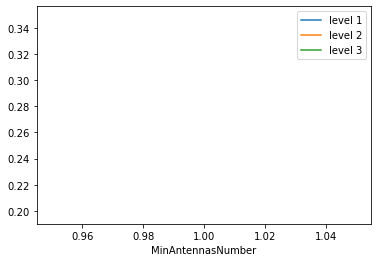

In [256]:
RecallCleanedDF = ResultsRecallDf.dropna(axis=0)
#print(RecallCleanedDF.info(verbose=True))

RecallCleanedDFbyLevel = []
for level in range(0,MaxAnomLevel+1):
    RecallCleanedDFbyLevel.append(RecallCleanedDF[RecallCleanedDF.AlertLevel==level])
    
TotalEECount = len(RecallCleanedDFbyLevel[0].index)
print("Total ExpectedEvents that were inside the Detection set : " + str(TotalEECount))

RecallRateByAlertLevelsAndAntennasNumber = []

#for MinAntennasNb in range(0,10):
for MinAntennasNb in range(0,1):
    for level in range(1,MaxAnomLevel+1):
        LevelDF = RecallCleanedDFbyLevel[level]

        rate = len(LevelDF[LevelDF.AntennasActivity>MinAntennasNb].index) / TotalEECount
        
        RecallRateByAlertLevelsAndAntennasNumber.append({"AlertLevel":level, "MinAntennasNumber":MinAntennasNb+1, "RecallRate":rate})
        
        print("When at least " + str(MinAntennasNb+1) + " antennas are required, Recall Rate for level " + str(level) + " is : " + str(rate*100))
        
        SummarizedIndicators.append({'method':MethodName, 'indicator':'recall (event)', 'level':level, 'value':rate})


RRbyALandAN = pd.DataFrame(RecallRateByAlertLevelsAndAntennasNumber)

df1 = RRbyALandAN[RRbyALandAN["AlertLevel"] == 1].set_index("MinAntennasNumber")
df2 = RRbyALandAN[RRbyALandAN["AlertLevel"] == 2].set_index("MinAntennasNumber")
df3 = RRbyALandAN[RRbyALandAN["AlertLevel"] == 3].set_index("MinAntennasNumber")

ax = df1.plot(y="RecallRate", label="level 1")
df2.plot(y="RecallRate", ax=ax, label="level 2")
df3.plot(y="RecallRate", ax=ax, label="level 3")
ax.legend()
        
#print(RecallCleanedDF.describe())

In [257]:
#import os

IndicatorsSummaryDF = pd.DataFrame(SummarizedIndicators)

IndicatorsSummaryDF.info(verbose=True)

IndicatorsSummaryDF.to_csv(AggregatedResultsStoreCsvFile, mode='a', header=not os.path.exists(AggregatedResultsStoreCsvFile), index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   method     25 non-null     object 
 1   indicator  25 non-null     object 
 2   level      24 non-null     float64
 3   value      25 non-null     float64
dtypes: float64(2), object(2)
memory usage: 928.0+ bytes


In [159]:
IndicatorsSummaryDF

,method,indicator,level,value
0,Signature_SMS3G_6Thresh,no-skill recall (minute),1.0,0.002133
1,Signature_SMS3G_6Thresh,no-skill recall (minute),2.0,0.000765
2,Signature_SMS3G_6Thresh,no-skill recall (minute),3.0,0.000527
3,Signature_SMS3G_6Thresh,no-skill recall (minute),4.0,0.000286
4,Signature_SMS3G_6Thresh,no-skill recall (minute),5.0,0.000159
5,Signature_SMS3G_6Thresh,no-skill recall (minute),6.0,0.000056
6,Signature_SMS3G_6Thresh,no-skill precision (minute),NaN,0.002330
7,Signature_SMS3G_6Thresh,precision (minute),1.0,0.002019
8,Signature_SMS3G_6Thresh,precision (minute),2.0,0.003033
9,Signature_SMS3G_6Thresh,precision (minute),3.0,0.002933


In [107]:
import math 

# now computing the floor recall rate in function of expected frequency rates of alerts
Level1Freq = 1. / (60.*4.)
Level2Freq = 1. / (60.*24.)
Level3Freq = 1. / (7.*60.*24.)

LevelFreqs = [1./(60.*4.), 1./(60.*24.), 1./(7.*60.*24.)]


LevelExpSum = [0.,0.,0.]
LevelExpNum = [0.,0.,0.]

#Level1ExpSum = 0.
#Level1ExpNumber = 0
#Level2ExpSum = 0.
#Level2ExpNumber = 0
#Level3ExpSum = 0.
#Level3ExpNumber = 0


for er in ResultsForNoSkillRecall:
    
    LineResults = []
    ExpectedValues = [er['EventLength']]
    
    
    for i in range(0,3):
        LineResult = 1. - math.pow(1.-LevelFreqs[i], er['EventLength'])
        #LineResult = 1. - math.pow(1.-LevelFreqs[i], er['EventLength']/er['AntennasNumber'])
        #LineResult = 1. - math.pow(math.pow(1.-LevelFreqs[i], er['EventLength']/er['AntennasNumber']), er['AntennasNumber'])
        LineResults.append(LineResult)
        LevelExpSum[i] += LineResult
        LevelExpNum[i] += 1
        ExpectedValue = LevelFreqs[i]*er['EventLength']
        ExpectedValues.append(ExpectedValue)
    ExpectedValues[0] = ExpectedValues[0]-ExpectedValues[1]

    print("[ " + er['Surname'])
    print(". " + str(er['EventLength']) + " min in total, for " + str(er['AntennasNumber']) + " antennas - mean time : " + str(er['EventLength']/er['AntennasNumber']) + " ; corresponding probabilities : " + str(LineResults))
    print(". measured values : " + str(er['TimeSpentOnAlert']) + " while expected values are " + str(ExpectedValues) + " ]")
    
for i in range(0,3):
    print("found no skill recall rate, level " + str(i+1) + " : " + str(100. * LevelExpSum[i] / LevelExpNum[i]) )
    
    

[ Concert Ninho
. 2115 min in total, for 9 antennas - mean time : 235.0 ; corresponding probabilities : [0.999853854891085, 0.7699043573449962, 0.1892794323452065]
. measured values : [2081, 34, 25, 21, 1, 0, 0] while expected values are [2106.1875, 8.8125, 1.46875, 0.20982142857142858] ]
[ Concert Hyphen Hyphen
. 2115 min in total, for 9 antennas - mean time : 235.0 ; corresponding probabilities : [0.999853854891085, 0.7699043573449962, 0.1892794323452065]
. measured values : [2115, 0, 0, 0, 0, 0, 0] while expected values are [2106.1875, 8.8125, 1.46875, 0.20982142857142858] ]
[ Concert Take That
. 2350 min in total, for 10 antennas - mean time : 235.0 ; corresponding probabilities : [0.9999452165717877, 0.8045618571132205, 0.20796245709391326]
. measured values : [2350, 0, 0, 0, 0, 0, 0] while expected values are [2340.2083333333335, 9.791666666666666, 1.6319444444444444, 0.23313492063492064] ]
[ Concert Maroon 5
. 2350 min in total, for 10 antennas - mean time : 235.0 ; correspondin

In [44]:
import math 

# now computing the floor recall rate in function of expected frequency rates of alerts

LevelFreqs = [1./(60.*4.), 1./(60.*24.), 1./(7.*60.*24.)]

Durations = [(60.*4.), (60.*24.), (7.*60.*24.)]

for i in range(0,3):
    for j in range(0,3):
        print("Duration : " + str(Durations[i]) + " - level " + str(1+j) + " probability (%) : " + str(100 * (1. - math.pow(1.-LevelFreqs[j], Durations[i]))))


Duration : 240.0 - level 1 probability (%) : 63.28883076920171
Duration : 240.0 - level 2 probability (%) : 15.35672825922253
Duration : 240.0 - level 3 probability (%) : 2.3529466663724463
Duration : 1440.0 - level 1 probability (%) : 99.75521246410554
Duration : 1440.0 - level 2 probability (%) : 63.22483317190925
Duration : 1440.0 - level 3 probability (%) : 13.312824347661344
Duration : 10080.0 - level 1 probability (%) : 100.0
Duration : 10080.0 - level 2 probability (%) : 99.90903327470303
Duration : 10080.0 - level 3 probability (%) : 63.213880757104555


## Activity ratios per alert level when matched with events

In [42]:
    
TotalEECount = len(RecallCleanedDFbyLevel[0].index)
print("Total ExpectedEvents that were inside the Detection set : " + str(TotalEECount))

DFLevel0 = RecallCleanedDFbyLevel[0][['AntennasActivity','TimeSpentOnAlert']].reset_index().drop(columns=['index'])
DFLevel1 = RecallCleanedDFbyLevel[1][['AntennasActivity','TimeSpentOnAlert']].reset_index().drop(columns=['index'])
DFLevel2 = RecallCleanedDFbyLevel[2][['AntennasActivity','TimeSpentOnAlert']].reset_index().drop(columns=['index'])
DFLevel3 = RecallCleanedDFbyLevel[3][['AntennasActivity','TimeSpentOnAlert']].reset_index().drop(columns=['index'])
#print(DFLevel0.describe())
#print(DFLevel1.describe())

# total minutes and antennas selected per event are 
TotalsDF = DFLevel0.add(DFLevel1)
#print(TotalsDF.describe())

RatiosDFLvl = [ DFLevel1.div(TotalsDF), DFLevel2.div(TotalsDF), DFLevel3.div(TotalsDF) ]


RecallRateByAlertLevelsAndAntennasRatio = []

for AntennasNbPercent in range(1,101):
    
    thresh = 0.01 * AntennasNbPercent
    
    for level in range(1,4):
        LevelDF = RatiosDFLvl[level-1]

        rate = len(LevelDF[LevelDF.AntennasActivity>thresh].index) / TotalEECount
        
        RecallRateByAlertLevelsAndAntennasRatio.append({"AlertLevel":level, "AntennasThresh":thresh, "RecallRate":rate})
        
        #print("When at least " + str(round(thresh*100)) + "% of antennas are required, Recall Rate for level " + str(level) + " is : " + str(rate))

      
RRbyALandAR = pd.DataFrame(RecallRateByAlertLevelsAndAntennasRatio)

dfa1 = RRbyALandAR[RRbyALandAR["AlertLevel"] == 1].set_index("AntennasThresh")
dfa2 = RRbyALandAR[RRbyALandAR["AlertLevel"] == 2].set_index("AntennasThresh")
dfa3 = RRbyALandAR[RRbyALandAR["AlertLevel"] == 3].set_index("AntennasThresh")

ax = dfa1.plot(y="RecallRate", label="level 1")
dfa2.plot(y="RecallRate", ax=ax, label="level 2")
dfa3.plot(y="RecallRate", ax=ax, label="level 3")
ax.legend()






RecallRateByAlertLevelsAndTimeRatio = []

for AntennasTimePercent in range(1,31):
    
    thresh = 0.01 * AntennasTimePercent
    
    for level in range(1,4):
        LevelDF = RatiosDFLvl[level-1]

        rate = len(LevelDF[LevelDF.TimeSpentOnAlert>thresh].index) / TotalEECount
        
        RecallRateByAlertLevelsAndTimeRatio.append({"AlertLevel":level, "TimeThresh":thresh, "RecallRate":rate})
        
        #print("When at least " + str(round(thresh*100)) + "% of time on alert is required, Recall Rate for level " + str(level) + " is : " + str(rate))

      
RRbyALandTR = pd.DataFrame(RecallRateByAlertLevelsAndTimeRatio)

dfb1 = RRbyALandTR[RRbyALandTR["AlertLevel"] == 1].set_index("TimeThresh")
dfb2 = RRbyALandTR[RRbyALandTR["AlertLevel"] == 2].set_index("TimeThresh")
dfb3 = RRbyALandTR[RRbyALandTR["AlertLevel"] == 3].set_index("TimeThresh")

bx = dfb1.plot(y="RecallRate", label="level 1")
dfb2.plot(y="RecallRate", ax=bx, label="level 2")
dfb3.plot(y="RecallRate", ax=bx, label="level 3")
bx.legend()











NameError: name 'RecallCleanedDFbyLevel' is not defined